### CNN Model

The objective of this project is to create an image classification model by classifying whether a histological scan contains cancer cells or not.

In [1]:
import glob
import sys
import os
import shutil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import random
from skimage.io import imread

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, SeparableConv2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
# For reproducible results:
from numpy.random import seed
seed(1)
%matplotlib inline

In [2]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2427854971895999143,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 2482395109313013776
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11140869696
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11567112881350665118
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 17914472837578740917
 physical_device_desc: "device: XLA_GPU device"]

In [2]:
glob.glob("../input/tumor-detection/data/*")

['../input/tumor-detection/data/ADIMUC',
 '../input/tumor-detection/data/STRMUS',
 '../input/tumor-detection/data/TUMSTU']

In [3]:
# from distutils.dir_util import copy_tree
# copy_tree("/a/b/c", "/x/y/z")

In [4]:
len(glob.glob('../data/ADIMUC/*'))

3977

In [5]:
len(glob.glob('../data/STRMUS/*'))

4000

In [6]:
len(glob.glob('../data/TUMSTU/*'))

4000

In [7]:
# Built train test directories
adimuc = glob.glob('../data/ADIMUC/*')
strmus = glob.glob('../data/STRMUS/*')
tumstu = glob.glob('../data/TUMSTU/*')

In [8]:
# BINARY CASE
non_cancer = adimuc + strmus
cancer = tumstu

In [9]:
num_train_non_cancer = int(0.7 * len(non_cancer))
num_train_cancer = int(0.7 * len(cancer))

In [10]:
num_train_non_cancer

5583

In [11]:
num_train_cancer

2800

In [61]:
train_non_cancer = random.sample(non_cancer, num_train_non_cancer)
train_cancer = random.sample(cancer, num_train_cancer)

In [63]:
test_non_cancer = list(set(non_cancer).difference(set(train_non_cancer)))
test_cancer = list(set(cancer).difference(set(train_cancer)))

In [80]:
os.mkdir("../data_cnn/")

In [81]:
os.mkdir("../data_cnn/train")
os.mkdir("../data_cnn/test")

os.mkdir("../data_cnn/train/non_cancer")
os.mkdir("../data_cnn/train/cancer")

os.mkdir("../data_cnn/test/non_cancer")
os.mkdir("../data_cnn/test/cancer")

In [86]:
print(train_non_cancer[0])
print(test_non_cancer[0])
print(train_cancer[0])
print(test_cancer[0])

../data/STRMUS/MUS-FWIEPPHAPGKM.png
../data/STRMUS/MUS-KRSNHLAEYIQY.png
../data/TUMSTU/TUM-CAKRSVSVSMFS.png
../data/TUMSTU/STU-CTPFHVKQGPTG.png


In [87]:
print(len(train_non_cancer))
print(len(test_non_cancer))
print(len(train_cancer))
print(len(test_cancer))

5583
2394
2800
1200


In [88]:
for img in train_non_cancer:
    shutil.copy2(img, "../data_cnn/train/non_cancer")

print('done')

for img in test_non_cancer:
    shutil.copy2(img, "../data_cnn/test/non_cancer")
    
print('done')

for img in train_cancer:
    shutil.copy2(img, "../data_cnn/train/cancer")
    
print('done')

for img in test_cancer:
    shutil.copy2(img, "../data_cnn/test/cancer")
    
print('done')

done
done
done
done


In [3]:
train_directory = "../data_cnn/train"
test_directory = "../data_cnn/test"

cancer_train = glob.glob(f"{train_directory}/cancer/*")
non_cancer_train = glob.glob(f"{train_directory}/non_cancer/*")

cancer_test = glob.glob(f"{test_directory}/cancer/*")
non_cancer_test = glob.glob(f"{test_directory}/non_cancer/*")

print(f"Total training CANCER images: {len(cancer_train)}")
print(f"Total training NON CANCER images: {len(non_cancer_train)}")
print(f"Total test CANCER images: {len(cancer_test)}")
print(f"Total train NON CANCER images: {len(non_cancer_test)}")
print("--")
print("Total training images:", len(glob.glob(f'{train_directory}/*/*')))
print("Total test images:", len(glob.glob(f'{test_directory}/*/*')))

Total training CANCER images: 2800
Total training NON CANCER images: 5583
Total test CANCER images: 1200
Total train NON CANCER images: 2394
--
Total training images: 8383
Total test images: 3594


Loading `train_data` and `test_data` which are the images transformed into floating point tensors.

In [4]:
train_img_gen = ImageDataGenerator(rescale=1./255, horizontal_flip = True)

train_data = train_img_gen.flow_from_directory(batch_size = 64,
                                               directory = train_directory,
                                               shuffle = True,
                                               target_size = (224,224),
                                               class_mode = 'binary')

test_img_gen = ImageDataGenerator(rescale=1./255)

test_data = test_img_gen.flow_from_directory(batch_size = 64,
                                             directory = test_directory,
                                             shuffle = True,
                                             target_size = (224,224),
                                             class_mode = 'binary')

Found 8383 images belonging to 2 classes.
Found 3594 images belonging to 2 classes.


## Convolutional Neural Network

#### Building the Model

Keras' Convolutional Neural Network model was implemented to classify whether a patient has pneumonia. There are 9 layers: **convolutional 2D layers**, **max pooling layers**, a single **flatten layer**, and **dense layers**. A CNN is used to capture the spatial distributions in an image by applying the aforementioned filters. 

**Conv2D Layer** is a set of learnable filters. Using the kernel filter, each filter transforms a part of the image to transform parts of the image. Conv2D also has two padding options:
1. Valid Padding - reduces convolved feature dimensionality
2. Same Padding - either increases or leaves the dimensionality alone.

Essentially, the first Conv2D layer captures low-level features such as the images' edges, colors, and gradient orientation. 

Added Conv2D layers allow the model to learn high-level features such as identifying the ribs and lungs in the images.

**Max Pooling Layers** reduce the spatial size of the convolved features and returns the max value from the portion of the image covered by the kernel for three reasons:
1. Decrease the computation power to process the data by dimensionality reduction
2. Extract dominant features by training the model
3. Reduce noise

**Dropout** is a regularization method that reduces overfitting by dropping a random proportion of nodes in the layer by setting their weights to 0. The randomly dropped nodes force the model to learn features in more generalized way.

**Flatten Layer** converts all of the learned features from the previous convolutional layers to a format that can be used by the densely connected neural layer

**Dense Layers** are used to generate the final prediction. It takes in the number of output nodes and has an activation function which we will use the sigmoid activation function. The values for the sigmoid range between 0 and 1 that allows the model to perform a binary classification. 

The first Conv2D is the input layer which takes in the images that have been converted to 224x224x3 floating point tensors.

`ReLu` (recified linear unit) is used as the activation function max(0,x) for the convolutional 2D layers. Essentially, until a threshold is hit, it doesn't activate!

[source](https://missinglink.ai/guides/keras/using-keras-flatten-operation-cnn-models-code-examples/)

In [5]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(224, 224 ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

#### Compiling the Model

The compile function has 3 parameters:
1. `optimizer` - controls the learning rate which defines how fast optimal weights for the model are calculated. We will use 'adam'
2. `loss` - defines the loss function which measures how far off the model's predictions are from the actual values. We will use binary crossentropy because we are predicting binary values. 
3. `metrics` - we will use the accuracy score to measure the rate of how well the model predicts correct classifications.

[source](https://missinglink.ai/guides/neural-network-concepts/convolutional-neural-network-build-one-keras-pytorch/)

In [6]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

#### Selecting Batch Size and Epochs
Batch size and epochs are hyperparameters for neural networks.

An `epoch` is one forward and backward pass of all the training examples.

A `batch` is the number of training examples in one forward/backward pass. The higher the batch size, the more memory space it occupies. Popular batch sizes are 32, 64, and 128.

The number of `iterations` is the number of batch sizes used to complete one epoch. 

I am going to run 20 epochs with batch sizes of 128. Essentially, I am giving my model 20 chances to learn patterns about the images.


[source](https://stackoverflow.com/questions/4752626/epoch-vs-iteration-when-training-neural-networks)

In [7]:
epochs = 20
batch_size = 128

In [8]:
total_train_images = len(glob.glob(f'{train_directory}/*/*'))
total_test_images = len(glob.glob(f'{test_directory}/*/*'))
print(total_train_images)
print(total_test_images)

8383
3594


In [9]:
%%time

history = model.fit_generator(
    train_data,
    steps_per_epoch = total_train_images // batch_size,
    epochs = epochs,
    validation_data = test_data,
    validation_steps = total_test_images // batch_size,
    verbose = 1
)

Epoch 1/20
65/65 [==============================] - 94s 1s/step - loss: 0.7274 - accuracy: 0.7398 - recall: 0.8345 - auc: 0.7914 - val_loss: 0.2486 - val_accuracy: 0.8945 - val_recall: 0.9686 - val_auc: 0.9710
Epoch 2/20
65/65 [==============================] - 93s 1s/step - loss: 0.2976 - accuracy: 0.8675 - recall: 0.9110 - auc: 0.9403 - val_loss: 0.3203 - val_accuracy: 0.8655 - val_recall: 0.8161 - val_auc: 0.9679
Epoch 3/20
65/65 [==============================] - 92s 1s/step - loss: 0.2472 - accuracy: 0.8911 - recall: 0.9187 - auc: 0.9591 - val_loss: 0.1992 - val_accuracy: 0.9196 - val_recall: 0.9407 - val_auc: 0.9748
Epoch 4/20
65/65 [==============================] - 92s 1s/step - loss: 0.2335 - accuracy: 0.9019 - recall: 0.9207 - auc: 0.9629 - val_loss: 0.2032 - val_accuracy: 0.9169 - val_recall: 0.9574 - val_auc: 0.9759
Epoch 5/20
65/65 [==============================] - 92s 1s/step - loss: 0.2107 - accuracy: 0.9115 - recall: 0.9268 - auc: 0.9698 - val_loss: 0.1867 - val_accura

Save the model:

In [164]:
# # Source: https://machinelearningmastery.com/save-load-keras-deep-learning-models/

# # serialize model to JSON
# model_json = model.to_json()
# with open("../assets/03_simple_cnn_model.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model.save_weights("../assets/03_simple_cnn_model.h5")
# print("Saved model to disk")

Saved model to disk


#### Evaluating the Model
Now I am going to evaluate how well the model performed by examining the loss function and accuracy metric.

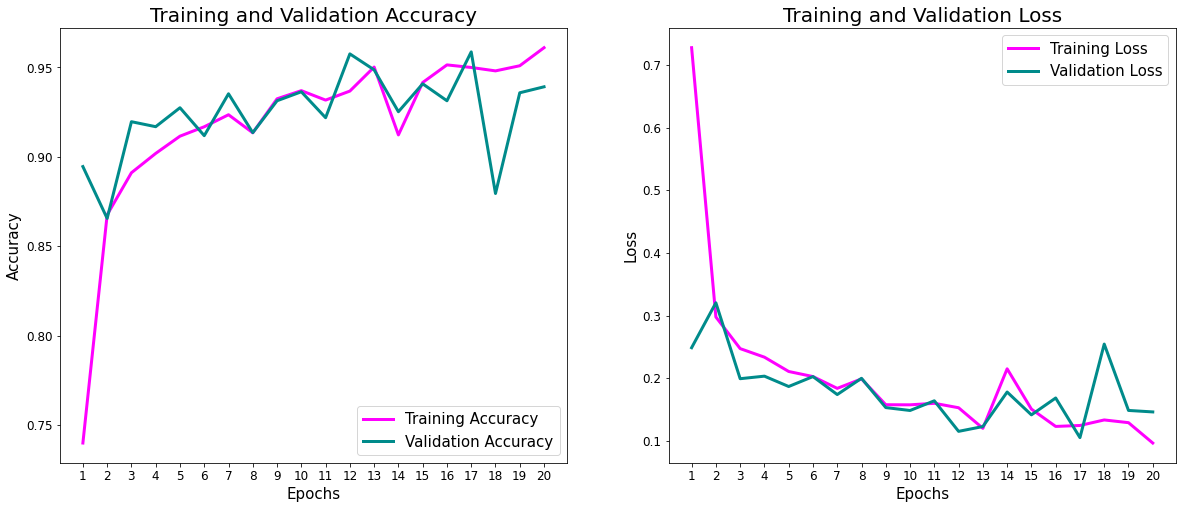

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', color = '#FF00FF', linewidth = 3)
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color = '#008B8B', linewidth = 3)
plt.legend(loc='lower right', prop={'size': 15})
plt.title('Training and Validation Accuracy', fontsize = 20)
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.xticks(epochs_range, range(1,epochs+1), fontsize = 12)
plt.yticks(fontsize = 12)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', color = '#FF00FF', linewidth = 3)
plt.plot(epochs_range, val_loss, label='Validation Loss', color = '#008B8B', linewidth = 3)
plt.legend(loc='upper right', prop={'size': 15})
plt.title('Training and Validation Loss', fontsize = 20)
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.xticks(epochs_range, range(1,epochs+1), fontsize = 12)
plt.yticks(fontsize = 12)

plt.savefig("cnn_acc_cancer_non_cancer.png", bbox_inches = 'tight')

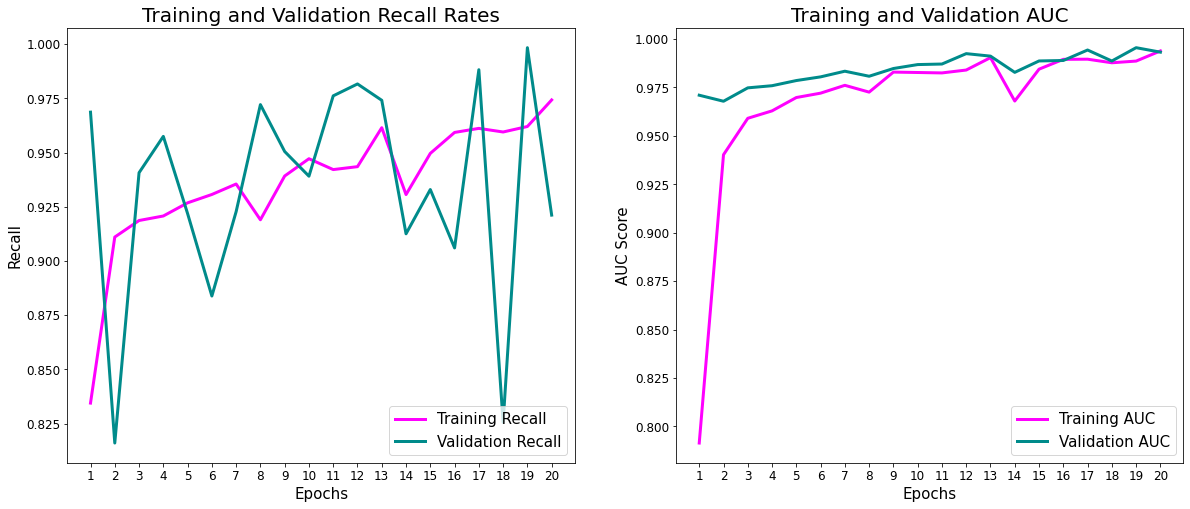

In [24]:
recall = history.history['recall']
val_recall = history.history['val_recall']

auc = history.history['auc']
val_auc = history.history['val_auc']

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, recall, label='Training Recall', color = '#FF00FF', linewidth = 3)
plt.plot(epochs_range, val_recall, label='Validation Recall', color = '#008B8B', linewidth = 3)
plt.legend(loc='lower right', prop={'size': 15})
plt.title('Training and Validation Recall Rates', fontsize = 20)
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Recall', fontsize = 15)
plt.xticks(epochs_range, range(1,epochs+1), fontsize = 12)
plt.yticks(fontsize = 12)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, auc, label='Training AUC', color = '#FF00FF', linewidth = 3)
plt.plot(epochs_range, val_auc, label='Validation AUC', color = '#008B8B', linewidth = 3)
plt.legend(loc='lower right', prop={'size': 15})
plt.title('Training and Validation AUC', fontsize = 20)
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('AUC Score', fontsize = 15)
plt.xticks(epochs_range, range(1,epochs+1), fontsize = 12)
plt.yticks(fontsize = 12)

plt.savefig("cnn_recall_auc_cancer_non_cancer.png", bbox_inches = 'tight')

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

recall = history.history['recall']
val_recall = history.history['val_recall']

auc = history.history['auc']
val_auc = history.history['val_auc']


In [22]:
print(f"Train Accuracy: {acc[-1]}")
print(f"Test Accuracy: {val_acc[-1]}")

print(f"Train Recall: {recall[-1]}")
print(f"Test Recall: {val_recall[-1]}")

print(f"Train AUC: {auc[-1]}")
print(f"Test AUC: {val_auc[-1]}")

Train Accuracy: 0.9610576629638672
Test Accuracy: 0.9391741156578064
Train Recall: 0.974247395992279
Test Recall: 0.9211409687995911
Train AUC: 0.9938395619392395
Test AUC: 0.9932123422622681


After running the CNN with 20 epochs with batch sizes of 128, it appears both training and validation accuracy scores converge to higher accuracy percentages, meaning the model is not overfit. Furthermore, the loss score for both training and validation decrease overall as the number of epochs increase. 

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0